# Análise da Camada Raw

Este notebook apresenta a **Análise de Qualidade de Dados** sobre o conjunto de *dados de voos nos Estados Unidos*, disponibilizado através do [**Kaggle**](https://www.kaggle.com/datasets/usdot/flight-delays). O objetivo é identificar padrões e inconsistências nos dados da camada **Raw**, a fim de apoiar a criação de regras de limpeza, transformação e oportunidades de melhoria para a camada **Silver**.

Esta análise explora a qualidade dos dados brutos do projeto de voos, com foco em quatro dimensões principais:

- completude (valores ausentes);
- integridade referencial entre tabelas;
- consistência temporal, de medidas e de nome;
- plausibilidade de valores numéricos, cardinalidade e textuais.

A investigação é guiada pelos arquivos:

- `airlines.csv` - companhias aéreas;
- `airports.csv` - aeroportos;
- `flights.csv ` - voos.

As transformações feitas ao longo do notebook têm caráter auxiliar, servem apenas para possibilitar as verificações de qualidade.


## 1. Configuração do ambiente


In [1]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

sns.set_theme(style="ticks", context="notebook")
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.spines.top": False,
    "axes.spines.right": False,
})


## 2. Carregamento dos dados

Nesta etapa o objetivo é apenas carregar os arquivos da camada Raw e inspecionar dimensões iniciais, sem aplicar nenhuma regra de negócio.


In [2]:
path_airlines = "stage/airlines.csv"
path_airports = "stage/airports.csv"
path_flights = "stage/flights.csv"

airlines_df = pd.read_csv(path_airlines, low_memory=False)
airports_df = pd.read_csv(path_airports, low_memory=False)
flights_df = pd.read_csv(path_flights, low_memory=False)

print("airlines:", airlines_df.shape)
print("airports:", airports_df.shape)
print("flights :", flights_df.shape)


airlines: (14, 2)
airports: (322, 7)
flights : (5819079, 31)


## 3. Qualidade dos dados de companhias aéreas (`airlines.csv`)

Começo pelo dataset de companhias aéreas porque ele funciona como domínio para a coluna de companhia na tabela de voos(principal). Se este cadastro estiver inconsistente, qualquer análise nos voos será afetada.


In [9]:
display(airlines_df.shape)

(14, 2)

In [8]:
display(airlines_df.head())

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


### 3.1 Completude e valores ausentes


In [5]:
airlines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IATA_CODE  14 non-null     object
 1   AIRLINE    14 non-null     object
dtypes: object(2)
memory usage: 356.0+ bytes


O resultado mostra que não existe valores nulos, porém existe uma inconsistências nos tipos. O Pandas não conseguiu identificar os tipos e os valores das colunas são vistas como *object*, apesar de serem claramentes *strings*. Essa é a primeira inconsistência a ser tratada na silver.


### 3.2 Unicidade do código IATA de companhia


In [7]:
total = len(airlines_df)
n_dist = airlines_df["IATA_CODE"].nunique(dropna=True)
n_dup = airlines_df.duplicated(subset="IATA_CODE").sum()

print("Total de linhas:", total)
print("Códigos IATA distintos:", n_dist)
print("Linhas com IATA_CODE duplicado:", n_dup)

if n_dup > 0:
    dup = airlines_df[airlines_df.duplicated(subset="IATA_CODE", keep=False)]
    display(dup.sort_values("IATA_CODE"))


Total de linhas: 14
Códigos IATA distintos: 14
Linhas com IATA_CODE duplicado: 0


Pelo resultado não existem valores absolutamente idênticos no dataset. Cada companhia aérea possui um código IATA único, indicando integridade referencial válida, podendo ser utilizada como chaves primárias.

### 3.3 Formato e padronização do código IATA


Esta verificação avalia se os códigos e nomes seguem um padrão estável de comprimento e capitalização.

In [10]:
for col in airlines_df.columns:
    print(f"\nColuna: {col}")
    print(airlines_df[col].unique())


Coluna: IATA_CODE
['UA' 'AA' 'US' 'F9' 'B6' 'OO' 'AS' 'NK' 'WN' 'DL' 'EV' 'HA' 'MQ' 'VX']

Coluna: AIRLINE
['United Air Lines Inc.' 'American Airlines Inc.' 'US Airways Inc.'
 'Frontier Airlines Inc.' 'JetBlue Airways' 'Skywest Airlines Inc.'
 'Alaska Airlines Inc.' 'Spirit Air Lines' 'Southwest Airlines Co.'
 'Delta Air Lines Inc.' 'Atlantic Southeast Airlines'
 'Hawaiian Airlines Inc.' 'American Eagle Airlines Inc.' 'Virgin America']


### 3.4 Consistência com a tabela de voos (`flights.csv`)


Esta verificação mede a integridade referencial entre voos e companhias. A existência de códigos em `flights` que não aparecem em `airlines` indica voos com companhia não cadastrada.

In [11]:
if "AIRLINE" in flights_df.columns and "IATA_CODE" in airlines_df.columns:
    codes_flights = set(flights_df["AIRLINE"].dropna().unique())
    codes_airlines = set(airlines_df["IATA_CODE"].dropna().unique())

    missing_codes = sorted(codes_flights - codes_airlines)

    print("Códigos de AIRLINE em flights sem cadastro em airlines:", len(missing_codes))
    print(missing_codes[:50])
else:
    print("Não foi possível cruzar AIRLINE com IATA_CODE (colunas ausentes).")


Códigos de AIRLINE em flights sem cadastro em airlines: 0
[]


O resultado indica que todas as companhias referenciadas em *flights* têm correspondência válida em *airlines*.

## 4. Qualidade dos dados de aeroportos (`airports.csv`)

O cadastro de aeroportos é o domínio de origem e destino dos voos. Problemas aqui impactam tanto integrações quanto análises geográficas.


In [14]:
display(airports_df.shape)

(322, 7)

In [15]:
display(airports_df.head())

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65,-75.44
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41,-99.68
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04,-106.61
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.45,-98.42
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.54,-84.19


### 4.1 Completude e valores ausentes

In [16]:
airports_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 98.4 KB


Os resultados mostram que existem colunas com inconsistências nos seus tipos e que existem dados faltando em duas colunas (LATITUDE e LONGITUDE).


#### 4.1.1 Análise de Valores Ausentes

In [17]:
airports_df[airports_df['LATITUDE'].isna() | airports_df['LONGITUDE'].isna()]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. Augustine Airport),St. Augustine,FL,USA,NaN,NaN


Existe três aeroportos sem dados de latitude e longitude, como são somentes esses dados, os valores podem serem corrigidos na **Silver**.

### 4.2 Cardinalidade e duplicatas no código de aeroporto


Nesta etapa verifico se o código de aeroporto pode ser tratado como identificador único. Duplicatas exigem uma escolha de registro canônico ou consolidação na Silver.


In [18]:
# Duplicidade pela chave natural
dup_iata = airports_df[airports_df.duplicated(subset=["IATA_CODE"], keep=False)]
print(f"Número de duplicatas pela chave IATA_CODE: {dup_iata.shape[0]}")

# Duplicatas completas
dup_full = airports_df[airports_df.duplicated()]
print(f"Número de tuplas completamente duplicadas: {dup_full.shape[0]}")

# Duplicatas por coluna
for col in airports_df.columns:
    dup_count = airports_df.duplicated(subset=[col]).sum()
    print(f"{col}: {dup_count} duplicatas")


Número de duplicatas pela chave IATA_CODE: 0
Número de tuplas completamente duplicadas: 0
IATA_CODE: 0 duplicatas
AIRPORT: 0 duplicatas
CITY: 14 duplicatas
STATE: 268 duplicatas
COUNTRY: 321 duplicatas
LATITUDE: 2 duplicatas
LONGITUDE: 2 duplicatas


Os resultados mostram quase o esperado, nenhum valor duplicado no `IATA_CODE` e `AIRPORT`, e algumas duplicatas para as outras colunas (como `CITY` e `STATE`). Porém, as colunas de coordenadas possuem 2 duplicatas e não 3 como esperado, isso pode ser justificado pelo fato do Pandas tratar o 'NaN' como "valor" e os outros 'NaN' como repetição, mas vamos investigar melhor.

In [20]:
print("Tuplas com nulos\n")
display(airports_df[airports_df[['LATITUDE', 'LONGITUDE']].isnull().any(axis=1)])

print("Tuplas com duplicatas nos nulos\n")
display(airports_df[airports_df.duplicated(subset=['LATITUDE'])])


Tuplas com nulos



,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. Augustine Airport),St. Augustine,FL,USA,NaN,NaN


Tuplas com duplicatas nos nulos



,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. Augustine Airport),St. Augustine,FL,USA,NaN,NaN


Confirmado, o método método `.duplicated()` não considera a primeira ocorrência de um valor como duplicada, mas sim como `unique`, sendo assim não entra na soma com o `.sum()`.

### 4.3 Plausibilidade de coordenadas geográficas


Aqui verifico se as coordenadas estão dentro de faixas fisicamente plausíveis. Valores fora dos intervalos aceitos precisam ser corrigidos ou removidos antes de análises espaciais.


In [21]:
invalid_lat = airports_df[
    airports_df["LATITUDE"].notna() &
    ((airports_df["LATITUDE"] < -90) | (airports_df["LATITUDE"] > 90))
]
invalid_lon = airports_df[
    airports_df["LONGITUDE"].notna() &
    ((airports_df["LONGITUDE"] < -180) | (airports_df["LONGITUDE"] > 180))
]

print("Aeroportos com LATITUDE fora de [-90, 90]:", len(invalid_lat))
print("Aeroportos com LONGITUDE fora de [-180, 180]:", len(invalid_lon))

if not invalid_lat.empty:
    display(invalid_lat.head())
if not invalid_lon.empty:
    display(invalid_lon.head())


Aeroportos com LATITUDE fora de [-90, 90]: 0
Aeroportos com LONGITUDE fora de [-180, 180]: 0


### 4.4 Consistência de Nomes

Aqui verifico se os nomes possuem algum caractere estranho nas colunas que possuem strings.


In [28]:
# Colunas textuais
text_cols = ['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'COUNTRY']

for col in text_cols:
    non_text = airports_df[~airports_df[col].astype(str).str.match(r'^[A-Za-zÀ-ÿ\s\-\.\']+$', na=False)]
    
    if not non_text.empty:
        print(f"\nColuna '{col}' possui valores suspeitos (não textuais). Tuplas afetadas: {len(non_text)}.")
        display(non_text[col])



Coluna 'AIRPORT' possui valores suspeitos (não textuais). Tuplas afetadas: 51.


12                                             Augusta Regional Airport (Bush Field)
24                                       Wilkes-Barre/Scranton International Airport
25                                      Kalamazoo/Battle Creek International Airport
38                                                Boise Airport (Boise Air Terminal)
40                           Jack Brooks Regional Airport (Southeast Texas Regional)
44                              Brownsville/South Padre Island International Airport
50                                      Bob Hope Airport (Hollywood Burbank Airport)
52                Bozeman Yellowstone International Airport (Gallatin Field Airport)
56                                                  Merle K. (Mudhole) Smith Airport
57                                    Del Norte County Airport (Jack McNamara Field)
58                                   Chattanooga Metropolitan Airport (Lovell Field)
60                                   Charleston International Air


Coluna 'CITY' possui valores suspeitos (não textuais). Tuplas afetadas: 7.


7                       Arcata/Eureka
24              Wilkes-Barre/Scranton
40               Beaumont/Port Arthur
68                   Champaign/Urbana
156           Iron Mountain/Kingsford
170                       Kailua/Kona
319    Fayetteville/Springdale/Rogers
Name: CITY, dtype: object

### 4.5 Consistência com a tabela de voos (`flights.csv`)


Esta verificação mede a integridade referencial entre voos e aeroportos. Códigos usados em `flights` que não aparecem em `airports` representam voos com origem ou destino desconhecidos no cadastro.


In [32]:
origin_codes = set(flights_df["ORIGIN_AIRPORT"].dropna().unique())
dest_codes = set(flights_df["DESTINATION_AIRPORT"].dropna().unique())
airport_codes = set(airports_df["IATA_CODE"].dropna().unique())

missing_orig = sorted(origin_codes - airport_codes)
missing_dest = sorted(dest_codes - airport_codes)

print("Códigos ORIGIN_AIRPORT sem cadastro em airports:", len(missing_orig))
print("Códigos DESTINATION_AIRPORT sem cadastro em airports:", len(missing_dest))

print("\nExemplos de ORIGIN_AIRPORT ausentes:", missing_orig[:10])
print("\nExemplos de DESTINATION_AIRPORT ausentes:", missing_dest[:10])


Códigos ORIGIN_AIRPORT sem cadastro em airports: 306
Códigos DESTINATION_AIRPORT sem cadastro em airports: 307

Exemplos de ORIGIN_AIRPORT ausentes: ['10135', '10136', '10140', '10141', '10146', '10154', '10155', '10157', '10158', '10165']

Exemplos de DESTINATION_AIRPORT ausentes: ['10135', '10136', '10140', '10141', '10146', '10154', '10155', '10157', '10158', '10165']


A verificação indica a existência de voos sem cadastro de aeroporto de origem, de destino ou de ambos. Como a proporção desses registros é pequena (inferior a 1%), a abordagem mais adequada é removê-los, evitando impacto nas análises subsequentes.

## 5. Qualidade dos dados de voos (`flights.csv`)

A tabela de voos concentra a maior parte da complexidade: datas, horários, atrasos e ligações com as dimensões. Nesta seção, as verificações são organizadas em blocos para evitar repetição e manter um fluxo único.


In [3]:
display(flights_df.shape)

(5819079, 31)

In [4]:
display(flights_df.head())

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.00,-22.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.00,-9.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.00,5.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.00,-9.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.00,-21.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### 5.1 Voos cancelados


Voos cancelados tendem a apresentar padrões próprios de nulos em horários e atrasos. Como o foco do projeto é análise dos **atrasos em voos realizados**, todas as linhas com `CANCELLED = 1` são removidas, assim como colunas associadas a cancelamentos.


In [5]:
cancelled = flights_df[flights_df["CANCELLED"] == 1]

print("Voos cancelados:", len(cancelled))


Voos cancelados: 89884


In [6]:
cols = ['CANCELLED', 'CANCELLATION_REASON']

flights_df = flights_df[flights_df['CANCELLED'] != 1].drop(columns=cols)


### 5.2 Valores ausentes


Vou visualizar primeiro o padrão geral de valores ausentes para entender quais colunas são potencialmente problemáticas. Em seguida, faço um recorte específico para grupos de colunas sensíveis, como atrasos (`*_DELAY`) e tempos (`*_TIME`).


In [7]:
flights_null = flights_df.isna().sum().to_frame("n_missing")
flights_null["pct_missing"] = (flights_null["n_missing"] / len(flights_df) * 100).round(2)
flights_null.sort_values("pct_missing", ascending=False, inplace=True)

display(flights_null[flights_null["pct_missing"] > 0])


,n_missing,pct_missing
WEATHER_DELAY,4665756,81.44
LATE_AIRCRAFT_DELAY,4665756,81.44
AIRLINE_DELAY,4665756,81.44
SECURITY_DELAY,4665756,81.44
AIR_SYSTEM_DELAY,4665756,81.44
ELAPSED_TIME,15187,0.27
ARRIVAL_DELAY,15187,0.27
AIR_TIME,15187,0.27
ARRIVAL_TIME,2629,0.05
TAXI_IN,2629,0.05


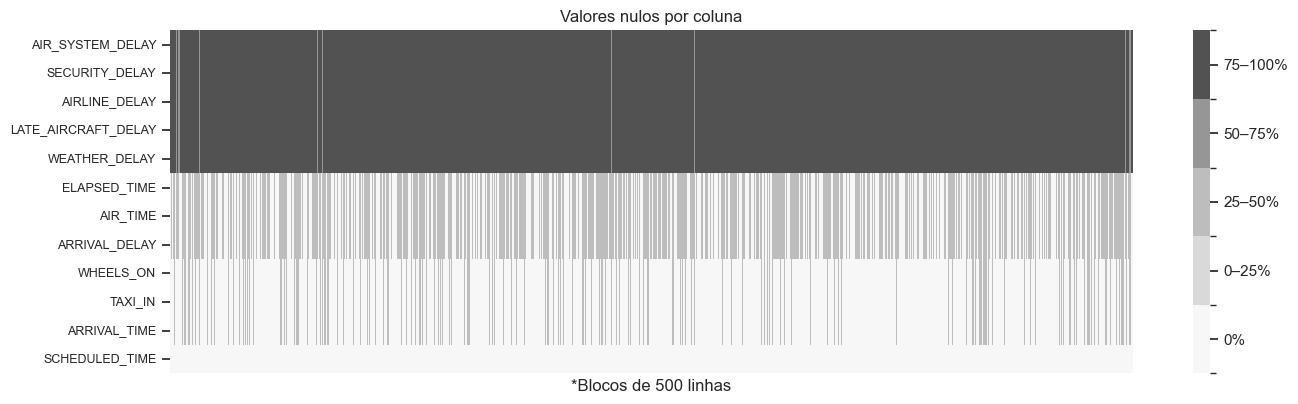

In [11]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Colunas com pelo menos um nulo
cols = (
    flights_df.isna()
    .mean()
    .loc[lambda s: s > 0]
    .sort_values(ascending=False)
    .index
    .tolist()
)

# Matriz binária de missing
miss = flights_df[cols].isna().to_numpy(dtype=np.uint8)

# Agregação por blocos (proporção de nulos)
block_size = 500
n_rows, n_cols = miss.shape
n_blocks = int(np.ceil(n_rows / block_size))

blk = np.zeros((n_blocks, n_cols), dtype=float)

for i in range(n_blocks):
    s = i * block_size
    e = min((i + 1) * block_size, n_rows)
    blk[i] = miss[s:e].mean(axis=0) * 100.0  # % de nulos no bloco

# Quantização em faixas semânticas
bins = [0, 0.01, 25, 50, 75, 100]
labels = [
    "0%",
    "0–25%",
    "25–50%",
    "50–75%",
    "75–100%",
]

blk_q = np.digitize(blk, bins=bins, right=True)

# Colormap
cmap = ListedColormap([
    "#f7f7f7",  # 0%
    "#d9d9d9",  # baixo
    "#bdbdbd",  # médio
    "#969696",  # alto
    "#525252",  # muito alto
])
norm = BoundaryNorm(range(len(labels) + 1), cmap.N)

# Plot
plt.figure(figsize=(14, 0.35 * len(cols)))

ax = sns.heatmap(
    blk_q.T,
    cmap=cmap,
    norm=norm,
    cbar=True,
    xticklabels=False,
    yticklabels=cols
)

# Colorbar categórica
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.arange(0.5, len(labels) + 0.5))
cbar.set_ticklabels(labels)

ax.tick_params(axis="y", labelsize=9)

plt.title("Valores nulos por coluna")
plt.xlabel(f"*Blocos de {block_size} linhas")

plt.tight_layout()
plt.show()


#### 5.2.1 Valores ausentes em colunas de atraso (`*_DELAY`)


Nesta etapa o foco é avaliar o motivo das colunas de atrasos possuirem altas taxas de nulos. Por exemplo, se os atrasos estão bem preenchidos ou se determinados tipos de atraso são informados com baixa frequência.


,n_missing,pct_missing
AIR_SYSTEM_DELAY,4665756,81.44
SECURITY_DELAY,4665756,81.44
AIRLINE_DELAY,4665756,81.44
LATE_AIRCRAFT_DELAY,4665756,81.44
WEATHER_DELAY,4665756,81.44
ARRIVAL_DELAY,15187,0.27
DEPARTURE_DELAY,0,0.00


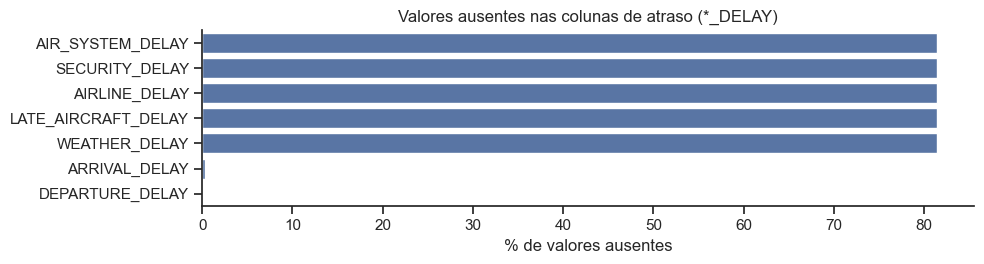

In [19]:
delay_cols = [c for c in flights_df.columns if c.endswith("DELAY")]

delay_null = flights_null.loc[delay_cols].copy() if delay_cols else pd.DataFrame()
delay_null = delay_null.sort_values("pct_missing", ascending=False)
display(delay_null)

plt.figure(figsize=(10, 0.4 * max(4, len(delay_null))))
sns.barplot(data=delay_null.reset_index(), x="pct_missing", y="index")
plt.xlabel("% de valores ausentes")
plt.ylabel("")
plt.title("Valores ausentes nas colunas de atraso (*_DELAY)")
plt.tight_layout()
plt.show()


Esses ~81% de dados faltantes nas colunas de motivo de atraso (*_DELAY) pode está ocorrendo porque esses campos só são preenchidos para voos que chegaram atrasados. Vamos verificar se para voos que chegaram no horário ou adiantados, esses campos estão de fato vazios.

In [23]:
on_time_or_early = flights_df[flights_df['ARRIVAL_DELAY'] <= 0]

reason_columns = [
    'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 
    'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'
]

non_null_counts = on_time_or_early[reason_columns].notnull().sum()
print("Contagem de valores preenchidos para voos pontuais:")
print(non_null_counts)

Contagem de valores preenchidos para voos pontuais:
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
dtype: int64


Como de esperado a saída mostra *0* para todas as colunas. Isso confirma que os motivos de atraso só são registrados para voos com **ARRIVAL_DELAY** > *0*, e que os valores nulos são, na verdade, zeros por regras de negócios. Porém, ainda temos os valores da coluna **ARRIVAL_DELAY**. Um dos motivos que os dados de chegada (**ARRIVAL_DELAY**, **ARRIVAL_TIME**, etc.) estão faltando, é porque os voos podem terem sidos desviados (**DIVERTED**=*1*) para outros aeroportos. Vou filtrar todas as linhas com **ARRIVAL_DELAY** nulo e verificar se a coluna **DIVERTED** está marcada como 1 (true).

In [26]:
missing_arrival_delay = flights_df[flights_df['ARRIVAL_DELAY'].isnull()]
diverted_counts = missing_arrival_delay['DIVERTED'].value_counts()

print("Status de desvio para voos com atraso na chegada nulo:")
print(diverted_counts)

Status de desvio para voos com atraso na chegada nulo:
DIVERTED
1    15187
Name: count, dtype: int64


O resultado confirma a hipótese, os voos com **ARRIVAL_DELAY** nulos são os desviados.

#### 5.2.2 Valores ausentes em colunas de tempo (`*_TIME`)


Aqui a intenção é verificar se horários de partida, chegada e tempos derivados estão suficientemente completos para permitir reconstruir a linha do tempo da maioria dos voos.


,n_missing,pct_missing
ELAPSED_TIME,15187,0.27
AIR_TIME,15187,0.27
ARRIVAL_TIME,2629,0.05
DEPARTURE_TIME,0,0.00
SCHEDULED_TIME,1,0.00


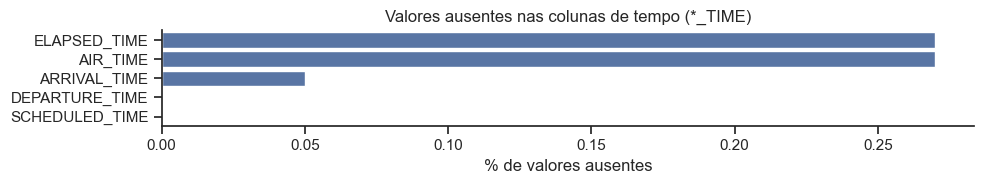

In [28]:
time_cols = [c for c in flights_df.columns if c.endswith("TIME")]

time_null = flights_null.loc[time_cols].copy() if time_cols else pd.DataFrame()
time_null = time_null.sort_values("pct_missing", ascending=False)
display(time_null)

plt.figure(figsize=(10, 0.4 * max(4, len(time_null))))
sns.barplot(data=time_null.reset_index(), x="pct_missing", y="index")
plt.xlabel("% de valores ausentes")
plt.ylabel("")
plt.title("Valores ausentes nas colunas de tempo (*_TIME)")
plt.tight_layout()
plt.show()


O número de valores nulos para **ELAPSED_TIME** e **AIR_TIME** é exatamente o mesmo de **ARRIVAL_DELAY**. A causa é a mesma que já confirmada, os voos desviados (**DIVERTED=1**). O **ELAPSED_TIME** (tempo total de portão a portão) e o **AIR_TIME** (tempo no ar) são métricas que dependem da conclusão de um voo. Se o voo foi desviado, essas durações para a rota planejada não são finalizadas e, portanto, não são registradas. Vou confirmar a relação entre **ELAPSED_TIME** nulo e **DIVERTED**.

In [29]:
# Filtra onde ELAPSED_TIME é nulo
null_elapsed_time = flights_df[flights_df['ELAPSED_TIME'].isnull()]

# Conta os valores da coluna 'DIVERTED' para essas linhas
diverted_status = null_elapsed_time['DIVERTED'].value_counts()

print("Status de desvio para voos com ELAPSED_TIME nulo:")
print(diverted_status)


Status de desvio para voos com ELAPSED_TIME nulo:
DIVERTED
1    15187
Name: count, dtype: int64


O resultado confirma a hipótese, todos os **15.187** registros correspondem a voos onde **DIVERTED** é igual a 1. Vou investigar as relações de outras colunas com a **DIVERTED**.

In [31]:
time_cols = [c for c in flights_df.columns if c.endswith("TIME")]

# Para cada uma, verificar a proporção de nulos com base em DIVERTED
for col in time_cols:
    summary = (
        flights_df.groupby(["DIVERTED"])[col]
        .apply(lambda x: x.isna().mean() * 100)
        .reset_index(name="%_missing")
        .sort_values("%_missing", ascending=False)
    )
    print(f"\nPadrões de ausência para {col}:")
    display(summary)


Padrões de ausência para DEPARTURE_TIME:


,DIVERTED,%_missing
0,0,0.00
1,1,0.00



Padrões de ausência para SCHEDULED_TIME:


,DIVERTED,%_missing
1,1,0.01
0,0,0.00



Padrões de ausência para ELAPSED_TIME:


,DIVERTED,%_missing
1,1,100.00
0,0,0.00



Padrões de ausência para AIR_TIME:


,DIVERTED,%_missing
1,1,100.00
0,0,0.00



Padrões de ausência para ARRIVAL_TIME:


,DIVERTED,%_missing
1,1,17.31
0,0,0.00


A coluna **DEPARTURE_TIME** está 100% preenchida, então sabemos que todos os voos decolaram. Eles não têm **ARRIVAL_TIME** em ~17% dos casos, mas provavelmente não são os mesmos voos desviados que já identificamos. A hipótese mais forte é que esses são voos que retornaram ao aeroporto de origem.

Essa hipótese pode ser verificada se, para esses voos, o aeroporto de origem é o mesmo que o de destino (o que seria impossível em um voo normal) ou, se eles possuem tempo de voo (**AIR_TIME**) mas não dados de chegada (**WHEELS_ON**, **TAXI_IN**). Como **AIR_TIME** tem mais nulos, vou usar uma abordagem diferente: *verificar se a soma dos tempos de voo conhecidos não faz sentido*.

In [32]:
null_arrival_time = flights_df[flights_df['ARRIVAL_TIME'].isnull()]
non_diverted_null_arrival = null_arrival_time[null_arrival_time['DIVERTED'] == 0]

print(f"Número de voos com ARRIVAL_TIME nulo e que não são 'DIVERTED': {len(non_diverted_null_arrival)}")


Número de voos com ARRIVAL_TIME nulo e que não são 'DIVERTED': 0


O resultado 0 indica que se não há voos com **ARRIVAL_TIME** nulo que não sejam desviados, isso significa que **TODOS** os voos com dados de chegada faltando (**ARRIVAL_TIME**, **WHEELS_ON**, etc.) são, na verdade, um subconjunto dos voos desviados. Isso apenas reforça a conclusão anterior, mas com mais certeza: a única causa para dados de tempo de chegada ausentes neste dataset é o fato de o voo ter sido desviado (**DIVERTED = 1**). Portanto, fica como ação para ser feita sobre os dados a remoção de todos os registros onde **DIVERTED = 1**. Vamos, então, confirmar essa conclusão.


In [ ]:
temp_df = flights_df.copy()
rows_before = len(temp_df)

temp_df = temp_df[temp_df['DIVERTED'] == 0]
rows_after = len(temp_df)

print(f"{rows_before - rows_after} linhas removidas")

temp_df = temp_df.drop(columns=['DIVERTED'])
print("Coluna 'DIVERTED' removida.\n")

flights_df = temp_df
flights_df.info(show_counts=True)


Agora vamos verificar se a coluna **ELAPSED_TIME** possui inconsistências.

Agora vou verificar se a coluna **ELAPSED_TIME** possui inconsistências.

In [37]:
flights_df['CALCULATED_ELAPSED_TIME'] = flights_df['TAXI_OUT'] + flights_df['AIR_TIME'] + flights_df['TAXI_IN']
flights_df['TIME_DIFFERENCE'] = flights_df['ELAPSED_TIME'] - flights_df['CALCULATED_ELAPSED_TIME']

inconsistent_flights = flights_df[flights_df['TIME_DIFFERENCE'] != 0]
count_inconsistent = len(inconsistent_flights)
total_flights = len(flights_df)

print(f"Total de voos analisados: {total_flights}")
print(f"Número de voos com tempo inconsistente: {count_inconsistent}")

if count_inconsistent > 0:
    print(inconsistent_flights['TIME_DIFFERENCE'].describe())


Total de voos analisados: 5714008
Número de voos com tempo inconsistente: 0


### 5.3 Duplicatas


Nesta etapa verifico se a combinação de data, companhia, número de voo e aeroportos de origem e destino gera duplicatas. Quando isso ocorre, a Silver precisa decidir se esses registros representam múltiplas medições do mesmo voo ou duplicidade real de dados.


In [45]:
candidate_cols = []
for col in ["YEAR", "MONTH", "DAY", "AIRLINE", "FLIGHT_NUMBER", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]:
    if col in flights_df.columns:
        candidate_cols.append(col)

if len(candidate_cols) >= 5:
    total = len(flights_df)
    n_unique = flights_df[candidate_cols].drop_duplicates().shape[0]
    n_dup = total - n_unique

    print("Colunas usadas como chave candidata:", candidate_cols)
    print("Total de linhas:", total)
    print("Linhas distintas pela chave candidata:", n_unique)
    print("Linhas potencialmente duplicadas:", n_dup)

    if n_dup > 0:
        sample = (
            flights_df
            .groupby(candidate_cols)
            .size()
            .reset_index(name="count")
            .query("count > 1")
            .head(20)
        )
        display(sample)
else:
    print("Não há colunas suficientes para formar uma chave natural.")


Colunas usadas como chave candidata: ['YEAR', 'MONTH', 'DAY', 'AIRLINE', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
Total de linhas: 5714008
Linhas distintas pela chave candidata: 5714008
Linhas potencialmente duplicadas: 0


### 5.4 Consistência temporal entre partida e chegada


Esta verificação identifica voos em que o horário de chegada ocorre antes ou no mesmo instante que o horário de partida, sob a convenção adotada na **Raw**. Parte desses casos pode corresponder a voos que cruzam a meia-noite sem ajuste de data; o restante é candidato a erro de registro.


In [48]:
from pandas import to_datetime

time_cols = ["YEAR", "MONTH", "DAY", "DEPARTURE_TIME", "ARRIVAL_TIME"]

if all(c in flights_df.columns for c in time_cols):
    tmp = flights_df[time_cols].copy()

    tmp["DATE"] = to_datetime(
        dict(year=tmp["YEAR"], month=tmp["MONTH"], day=tmp["DAY"]),
        errors="coerce"
    )

    dep_raw = tmp["DEPARTURE_TIME"].astype("float").round().astype("Int64")
    arr_raw = tmp["ARRIVAL_TIME"].astype("float").round().astype("Int64")

    dep_hh = (dep_raw // 100).astype("Int64")
    dep_mm = (dep_raw % 100).astype("Int64")
    arr_hh = (arr_raw // 100).astype("Int64")
    arr_mm = (arr_raw % 100).astype("Int64")

    tmp["DEP_MIN"] = dep_hh * 60 + dep_mm
    tmp["ARR_MIN"] = arr_hh * 60 + arr_mm

    tmp["DEP_TS"] = tmp["DATE"] + pd.to_timedelta(tmp["DEP_MIN"], unit="m")
    tmp["ARR_TS"] = tmp["DATE"] + pd.to_timedelta(tmp["ARR_MIN"], unit="m")

    mask = tmp["DEP_TS"].notna() & tmp["ARR_TS"].notna()
    inconsistent = tmp[mask & (tmp["ARR_TS"] <= tmp["DEP_TS"])]

    print("Voos com horários comparáveis:", mask.sum())
    print("Voos com ARR_TS <= DEP_TS:", len(inconsistent))

    if not inconsistent.empty:
        display(flights_df.loc[inconsistent.index, ["YEAR", "MONTH", "DAY", "DEPARTURE_TIME", "ARRIVAL_TIME"]].head())
else:
    print("Colunas necessárias para reconstruir timestamps não estão completas.")


Voos com horários comparáveis: 5714008
Voos com ARR_TS <= DEP_TS: 233278


,YEAR,MONTH,DAY,DEPARTURE_TIME,ARRIVAL_TIME
0,2015,1,1,"2,354.00",408.00
87,2015,1,1,527.00,511.00
1985,2015,1,1,827.00,824.00
2063,2015,1,1,829.00,821.00
2596,2015,1,1,903.00,851.00


Os resultados indicam que a maioria desses casos corresponde a voos que cruzam a meia-noite, o que é esperado dado que a camada **Raw** não ajusta a data de chegada. Um subconjunto menor, no entanto, apresenta chegada anterior à partida sem possibilidade de cruzamento de meia-noite, sendo tratado como possível inconsistência de registro. Vou investigar melhor.

In [49]:
delta = tmp["DEP_MIN"] - tmp["ARR_MIN"]

overnight = inconsistent[
    (tmp.loc[inconsistent.index, "DEP_MIN"] >= 18 * 60) &
    (tmp.loc[inconsistent.index, "ARR_MIN"] <= 6 * 60)
]

suspect = inconsistent.drop(index=overnight.index)

print("Casos overnight (não inconsistentes):", len(overnight))
print("Casos restantes (suspeitos):", len(suspect))


Casos overnight (não inconsistentes): 160473
Casos restantes (suspeitos): 72805


In [52]:
sus = tmp.loc[suspect.index].copy()

sus["delta_min_raw"] = sus["ARR_MIN"] - sus["DEP_MIN"]
sus["delta_min_adj"] = sus["delta_min_raw"] + 24 * 60

# Usa ELAPSED_TIME do flights_df
sus["ELAPSED_TIME"] = flights_df.loc[sus.index, "ELAPSED_TIME"]

sus["err_raw"] = (sus["delta_min_raw"] - sus["ELAPSED_TIME"]).abs()
sus["err_adj"] = (sus["delta_min_adj"] - sus["ELAPSED_TIME"]).abs()

tol = 15  # minutos de tolerância

sus["classification"] = np.select(
    [
        sus["err_adj"] <= tol,
        sus["err_raw"] <= tol,
    ],
    [
        "overnight_valido",
        "valido_sem_ajuste",
    ],
    default="inconsistente"
)

sus["classification"].value_counts()


classification
inconsistente    72805
Name: count, dtype: int64

A partir da análise, o resutlados mostraram que aproximadamente 72 mil registros (1,3% do total) cujos horários de partida e chegada não são compatíveis com o tempo total de voo informado, mesmo após considerar cruzamento de meia-noite. Esses registros são classificados como inconsistentes e tratados como erro de qualidade de dados, portanto, devem ser removidos na **Silver**.

### 5.5 Plausibilidade de distâncias e atrasos extremos


Aqui avalio se a distância dos voos é estritamente positiva e se os atrasos apresentam valores extremos. Distâncias não positivas são incompatíveis com a definição de voo e precisam ser corrigidas ou removidas. Atrasos muito elevados podem ser outliers legítimos ou erros de cadastro e exigem definição explícita de política de tratamento na Silver.


In [41]:
if "DISTANCE" in flights_df.columns:
    display(flights_df["DISTANCE"].describe())

    invalid_distance = flights_df[flights_df["DISTANCE"] <= 0]
    print("Voos com DISTANCE <= 0:", len(invalid_distance))
    if not invalid_distance.empty:
        display(invalid_distance.head())
else:
    print("Coluna DISTANCE não encontrada em flights.csv.")

for col in ["DEPARTURE_DELAY", "ARRIVAL_DELAY"]:
    if col in flights_df.columns:
        print(f"\nResumo de {col}:")
        display(flights_df[col].describe())


count   5,714,008.00
mean          824.46
std           608.66
min            31.00
25%           373.00
50%           650.00
75%         1,065.00
max         4,983.00
Name: DISTANCE, dtype: float64

Voos com DISTANCE <= 0: 0

Resumo de DEPARTURE_DELAY:


count   5,714,008.00
mean            9.29
std            36.89
min           -82.00
25%            -5.00
50%            -2.00
75%             7.00
max         1,988.00
Name: DEPARTURE_DELAY, dtype: float64


Resumo de ARRIVAL_DELAY:


count   5,714,008.00
mean            4.41
std            39.27
min           -87.00
25%           -13.00
50%            -5.00
75%             8.00
max         1,971.00
Name: ARRIVAL_DELAY, dtype: float64

A verificação confirma que todas as distâncias de voo são estritamente positivas, não sendo identificadas inconsistências na coluna **DISTANCE**. Em relação aos atrasos de partida e chegada, observam-se valores negativos (voos adiantados), o que é esperado, bem como valores extremos positivos. Esses atrasos severos podem representar eventos operacionais reais ou registros atípicos e, embora não caracterizem erro de qualidade na camada **Raw**, serão removidos na camada **Silver** para evitar distorções em análises agregadas.

## 6 Plano de Ação – Diretrizes para a camada **Silver**

De forma consolidada, os principais pontos identificados na análise da camada **Raw** e as respectivas ações para a transição para a **Silver** são:

- **Padronização e limpeza do dataset Airlines**

  - Converter os tipos dos atributos;
  - Renomear as colunas:
    - `IATA_CODE` → `AIRLINE_IATA_CODE`;
    - `AIRLINE` → `AIRLINE_NAME`;
  - Garantir unicidade do código da companhia aérea.

- **Padronização e limpeza do dataset Airports**

  - Converter os tipos dos atributos;
  - Renomear a coluna:
    - `IATA_CODE` → `AIRPORT_IATA_CODE`;
  - Remover a coluna `COUNTRY`;
  - Corrigir manualmente os valores de latitude e longitude para os aeroportos `ECP`, `PBG` e `UST`;
  - Garantir unicidade do código do aeroporto;
  - Validar a plausibilidade geográfica:
    - `LATITUDE` ∈ [−90, 90];
    - `LONGITUDE` ∈ [−180, 180].

- **Padronização e limpeza do dataset Flights**

  - Remover todos os voos com `CANCELLED = 1`;
  - Remover todos os voos com `DIVERTED = 1`;
  - Remover voos com inconsistência temporal real;
  - Remover as colunas `CANCELLED`, `DIVERTED` e `CANCELLATION_REASON`;
  - Consolidar `YEAR`, `MONTH` e `DAY` em uma única coluna `FLIGHT_DATE` (tipo `date`);
  - Remover as colunas `YEAR`, `MONTH` e `DAY` após a consolidação;
  - Converter os tipos dos atributos numéricos (`DISTANCE`, `*_DELAY`, `TAXI_OUT`, `TAXI_IN`, `AIR_TIME`, `ELAPSED_TIME`);
  - Converter os horários de partida e chegada para timestamp (`DEPARTURE_TIME_TS`, `ARRIVAL_TIME_TS`), ajustando corretamente voos que cruzam a meia-noite;
  - Preencher com `0` as colunas de motivo de atraso (`AIR_SYSTEM_DELAY`, `SECURITY_DELAY`, `AIRLINE_DELAY`, `LATE_AIRCRAFT_DELAY`, `WEATHER_DELAY`), uma vez que esses campos só são preenchidos quando `ARRIVAL_DELAY > 0`;
  - Não imputar valores ausentes em colunas de tempo ou atraso principal;
  - Validar que `ELAPSED_TIME` é compatível com a soma de `TAXI_OUT`, `AIR_TIME` e `TAXI_IN`;
  - Validar que `ARRIVAL_TIME_TS` é posterior a `DEPARTURE_TIME_TS`;
  - Validar que `ORIGIN_AIRPORT` é diferente de `DESTINATION_AIRPORT`;
  - Garantir que `DISTANCE` seja sempre estritamente positiva;
  - Validar que os códigos de companhia aérea presentes em `flights` existem no dataset `airlines`;
  - Validar que os aeroportos de origem e destino presentes em `flights` existem no dataset `airports`.

Essas diretrizes definem os **quality gates** e as regras de limpeza obrigatórias para a construção da camada **Silver** em formato de **tabela única (OBT)**, garantindo consistência estrutural e semântica para a posterior modelagem analítica na camada **Gold**.
